In [1]:
from gurobipy import *
from IPython.display import Image
from scipy.stats import poisson
import matplotlib.pyplot as plt

import random
import pandas as pd
import numpy as np
import math
import os
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


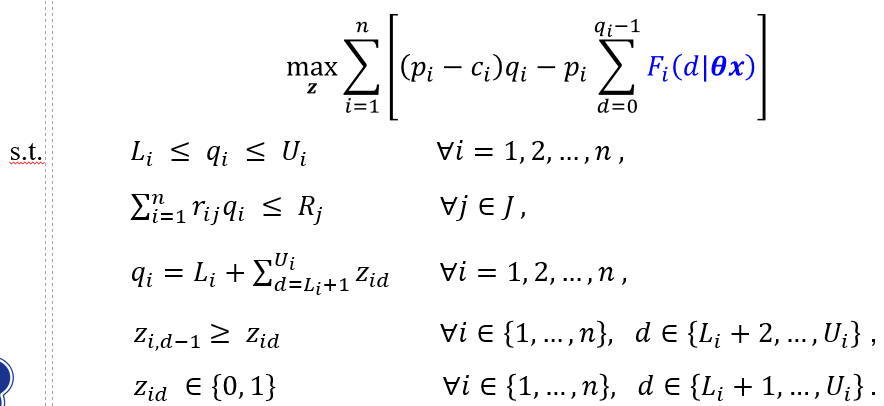

In [2]:
Image("objective_function.png")
# ![title](objective_function.png)

In [2]:
raw_df = pd.DataFrame()
files = os.listdir('data')
for f in files:
    if 'item' not in f:
        df = pd.read_csv('data/{}'.format(f))
        df['OilPrice_old'] = 0.0
        df['transactions_old'] = 0.0
        df['DayFromWagePaid_old'] = 0
        for i in range(1, len(df)):
            df['OilPrice_old'][i] = df['OilPrice'][i-1]
            df['transactions_old'][i] = df['transactions'][i-1]
            df['DayFromWagePaid_old'][i] = df['DayFromWagePaid'][i-1]
        raw_df = pd.concat([raw_df, df])

c:\Users\Johnson\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\Johnson\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\Johnson\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

KeyboardInterrupt: 

In [4]:
# date從 2013/01/02 到 2017/08/15
# onpromotion有 true, false, nan
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413706 entries, 0 to 1686
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1413706 non-null  object 
 1   item_nbr             1413706 non-null  float64
 2   unit_sales           1413706 non-null  float64
 3   onpromotion          632011 non-null   object 
 4   weekday              1413706 non-null  int64  
 5   DayFromWagePaid      1413706 non-null  int64  
 6   DayToWagePaid        1413706 non-null  int64  
 7   OilPrice             1413706 non-null  float64
 8   transactions         1413706 non-null  float64
 9   type                 1413706 non-null  object 
 10  OilPrice_old         1413706 non-null  float64
 11  transactions_old     1413706 non-null  float64
 12  DayFromWagePaid_old  1413706 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 151.0+ MB


In [5]:
raw_df = raw_df.drop(raw_df.loc[(raw_df['OilPrice_old']==0) & (raw_df['transactions_old']==0) & (raw_df['DayFromWagePaid_old']==0)].index)

In [6]:
# unit_sales必須大於等於0
# 去掉on promotion為空值的資料
# (raw_df['date']>='2014-01-01') & (raw_df['date']<='2014-12-31') & 
df = raw_df.loc[(raw_df['unit_sales']>=0) & (~raw_df['onpromotion'].isna())]
df['month'] = df['date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').month)

c:\Users\Johnson\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631969 entries, 454 to 1662
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 631969 non-null  object 
 1   item_nbr             631969 non-null  float64
 2   unit_sales           631969 non-null  float64
 3   onpromotion          631969 non-null  object 
 4   weekday              631969 non-null  int64  
 5   DayFromWagePaid      631969 non-null  int64  
 6   DayToWagePaid        631969 non-null  int64  
 7   OilPrice             631969 non-null  float64
 8   transactions         631969 non-null  float64
 9   type                 631969 non-null  object 
 10  OilPrice_old         631969 non-null  float64
 11  transactions_old     631969 non-null  float64
 12  DayFromWagePaid_old  631969 non-null  int64  
 13  month                631969 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 72.3+ MB


In [8]:
item_df = pd.read_csv('data/items.csv')
df = pd.merge(df, item_df[['item_nbr', 'family']], how='left', on='item_nbr')
dummied_df = pd.get_dummies(df.iloc[:, 0:], columns=['weekday', 'onpromotion', 'type', 'month', 'family'])
dummied_df = dummied_df.drop(['DayToWagePaid', 'weekday_6', 'onpromotion_True', 'type_Work', 'month_12', 'family_SEAFOOD'], axis=1)

In [9]:
dummied_df

,date,item_nbr,unit_sales,DayFromWagePaid,OilPrice,transactions,OilPrice_old,transactions_old,DayFromWagePaid_old,weekday_0,...,month_10,month_11,family_BREAD/BAKERY,family_DAIRY,family_DELI,family_EGGS,family_MEATS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE
0,2014-04-01,957098.0,4.0,1,99.690000,1847.0,101.570000,1862.0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2014-04-02,957098.0,4.0,2,99.600000,1899.0,99.690000,1847.0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2014-04-04,957098.0,1.0,4,101.160000,1875.0,100.290000,1789.0,3,0,...,0,0,0,1,0,0,0,0,0,0
3,2014-04-05,957098.0,6.0,5,100.916667,1393.0,101.160000,1875.0,4,0,...,0,0,0,1,0,0,0,0,0,0
4,2014-04-06,957098.0,1.0,6,100.673333,529.0,100.916667,1393.0,5,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631964,2017-07-14,1446726.0,1.0,14,46.530000,1867.0,46.060000,1679.0,13,0,...,0,0,0,1,0,0,0,0,0,0
631965,2017-07-15,1446726.0,3.0,0,46.360000,1338.0,46.530000,1867.0,14,0,...,0,0,0,1,0,0,0,0,0,0
631966,2017-07-16,1446726.0,1.0,1,46.190000,518.0,46.360000,1338.0,0,0,...,0,0,0,1,0,0,0,0,0,0
631967,2017-07-17,1446726.0,1.0,2,46.020000,1739.0,46.190000,518.0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [10]:
# len(list(dummied_df['item_nbr'].unique()))
## 833
# np.log2(833)
## 10

In [11]:
# 將產品編號做multi_hot_encoding
unique_item = list(dummied_df['item_nbr'].unique())
item_dict = {}
for index in range(len(unique_item)):
    item_dict[unique_item[index]] = ('000000000'+bin(index).split('0b')[1])[-10:]
item_dict

# 分別塞進dummied_df的欄位中
dummied_df['item_10'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][0]))
dummied_df['item_9'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][1]))
dummied_df['item_8'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][2]))
dummied_df['item_7'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][3]))
dummied_df['item_6'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][4]))
dummied_df['item_5'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][5]))
dummied_df['item_4'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][6]))
dummied_df['item_3'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][7]))
dummied_df['item_2'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][8]))
dummied_df['item_1'] = dummied_df['item_nbr'].apply(lambda row: int(item_dict[row][9]))


In [12]:
dummied_df

,date,item_nbr,unit_sales,DayFromWagePaid,OilPrice,transactions,OilPrice_old,transactions_old,DayFromWagePaid_old,weekday_0,...,item_10,item_9,item_8,item_7,item_6,item_5,item_4,item_3,item_2,item_1
0,2014-04-01,957098.0,4.0,1,99.690000,1847.0,101.570000,1862.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-04-02,957098.0,4.0,2,99.600000,1899.0,99.690000,1847.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-04-04,957098.0,1.0,4,101.160000,1875.0,100.290000,1789.0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-04-05,957098.0,6.0,5,100.916667,1393.0,101.160000,1875.0,4,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-04-06,957098.0,1.0,6,100.673333,529.0,100.916667,1393.0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631964,2017-07-14,1446726.0,1.0,14,46.530000,1867.0,46.060000,1679.0,13,0,...,1,1,0,1,0,0,0,0,0,0
631965,2017-07-15,1446726.0,3.0,0,46.360000,1338.0,46.530000,1867.0,14,0,...,1,1,0,1,0,0,0,0,0,0
631966,2017-07-16,1446726.0,1.0,1,46.190000,518.0,46.360000,1338.0,0,0,...,1,1,0,1,0,0,0,0,0,0
631967,2017-07-17,1446726.0,1.0,2,46.020000,1739.0,46.190000,518.0,1,1,...,1,1,0,1,0,0,0,0,0,0


In [13]:
dummied_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631969 entries, 0 to 631968
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   631969 non-null  object 
 1   item_nbr               631969 non-null  float64
 2   unit_sales             631969 non-null  float64
 3   DayFromWagePaid        631969 non-null  int64  
 4   OilPrice               631969 non-null  float64
 5   transactions           631969 non-null  float64
 6   OilPrice_old           631969 non-null  float64
 7   transactions_old       631969 non-null  float64
 8   DayFromWagePaid_old    631969 non-null  int64  
 9   weekday_0              631969 non-null  uint8  
 10  weekday_1              631969 non-null  uint8  
 11  weekday_2              631969 non-null  uint8  
 12  weekday_3              631969 non-null  uint8  
 13  weekday_4              631969 non-null  uint8  
 14  weekday_5              631969 non-nu

In [14]:
scaled_df = dummied_df.copy()
# scaled_df['OilPrice'] = (scaled_df['OilPrice'] - scaled_df['OilPrice'].mean()) / scaled_df['OilPrice'].std()
# scaled_df['transactions'] = (scaled_df['transactions'] - scaled_df['transactions'].mean()) / scaled_df['transactions'].std()
scaled_df['OilPrice_old'] = (scaled_df['OilPrice_old'] - scaled_df['OilPrice_old'].mean()) / scaled_df['OilPrice_old'].std()
scaled_df['transactions_old'] = (scaled_df['transactions_old'] - scaled_df['transactions_old'].mean()) / scaled_df['transactions_old'].std()
scaled_df['DayFromWagePaid_old'] = (scaled_df['DayFromWagePaid_old'] - scaled_df['DayFromWagePaid_old'].mean()) / scaled_df['DayFromWagePaid_old'].std()

# scaled_df['unit_sales'] = (scaled_df['unit_sales'] - scaled_df['unit_sales'].min()) / (scaled_df['unit_sales'].max() - scaled_df['unit_sales'].min())

scaled_df = scaled_df.drop(['DayFromWagePaid', 'OilPrice', 'transactions'], axis=1)

In [23]:
pd.set_option('display.max_columns', None)
scaled_df

,date,item_nbr,unit_sales,OilPrice_old,transactions_old,DayFromWagePaid_old,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,onpromotion_False,type_Holiday,type_Weekend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,family_BREAD/BAKERY,family_DAIRY,family_DELI,family_EGGS,family_MEATS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,item_10,item_9,item_8,item_7,item_6,item_5,item_4,item_3,item_2,item_1
0,2014-04-01,957098.0,4.0,2.498195,0.667328,-1.617790,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-04-02,957098.0,4.0,2.398799,0.638341,-1.390718,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-04-04,957098.0,1.0,2.430521,0.526256,-0.936575,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2014-04-05,957098.0,6.0,2.476518,0.692451,-0.709503,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-04-06,957098.0,1.0,2.463653,-0.239010,-0.482431,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631964,2017-07-14,1446726.0,1.0,-0.436610,0.313683,1.334144,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
631965,2017-07-15,1446726.0,3.0,-0.411761,0.676991,1.561216,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
631966,2017-07-16,1446726.0,1.0,-0.420749,-0.345296,-1.617790,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
631967,2017-07-17,1446726.0,1.0,-0.429737,-1.929938,-1.390718,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0


In [70]:
len(X_test)

189591

In [16]:
scaled_df['item_nbr'].value_counts()
scaled_df.reset_index(drop=True, inplace=True)

In [17]:
X = scaled_df.drop(['unit_sales'], axis=1)
y = scaled_df[['unit_sales']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69, stratify=scaled_df['item_nbr'])
model = LinearRegression(fit_intercept = True)
model.fit(X_train.iloc[:, 2:], y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_test.iloc[:, 2:])
mean_squared_error(y_test, y_pred)
model.score(X_test.iloc[:, 2:], y_test)
# r2_score(y_test, y_pred)

0.10642456571968972

In [19]:
model.coef_

array([[ 0.27337202,  0.37008663, -0.1365667 ,  3.18892654,  1.95261533,
         3.78200877,  1.65620271,  2.38118087,  3.13387799, -3.57265051,
        -1.13127336, -0.89214275,  0.07756524, -0.3207868 , -0.24584144,
        -0.17704909, -0.14335991, -0.27103363, -0.43208805, -0.57700837,
        -0.25797222, -0.28784367, -0.31636741,  1.62376374,  0.79421579,
        -1.84211638,  0.97954782,  2.96684268,  5.41261279,  2.8101789 ,
         7.73739197,  0.91148869,  0.84773244, -1.12193951, -0.04841449,
        -1.15375018,  0.78310787, -0.19595858,  0.77301549, -0.49281477,
        -0.75736398]])

In [20]:
model.intercept_

array([6.21601597])

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442378 entries, 289444 to 318100
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   442378 non-null  object 
 1   item_nbr               442378 non-null  float64
 2   OilPrice_old           442378 non-null  float64
 3   transactions_old       442378 non-null  float64
 4   DayFromWagePaid_old    442378 non-null  float64
 5   weekday_0              442378 non-null  uint8  
 6   weekday_1              442378 non-null  uint8  
 7   weekday_2              442378 non-null  uint8  
 8   weekday_3              442378 non-null  uint8  
 9   weekday_4              442378 non-null  uint8  
 10  weekday_5              442378 non-null  uint8  
 11  onpromotion_False      442378 non-null  uint8  
 12  type_Holiday           442378 non-null  uint8  
 13  type_Weekend           442378 non-null  uint8  
 14  month_1                442378 n

In [ ]:
# 預先設置每個品項的lambda 並用poisson分布產出x天的訓練資料
lambdas = [7, 13, 12, 10, 13, 10, 19, 21, 19, 5]
days_of_data = 35
train_percent = 0.7
train_day = math.ceil(days_of_data * train_percent)
test_day = days_of_data - train_day

train_demand = []
test_demand = []
for l in lambdas:
    raw_data = poisson.rvs(l, size = days_of_data)
    
    # 切分成訓練和測試資料
    train_demand.append(raw_data[:train_day])
    test_demand.append(raw_data[train_day:])

In [ ]:
def get_mu(item_nbr, month, weekday, promotion, type, oilprice, transactions, dayfromwagepaid):

    item_10 = int(item_dict[item_nbr][0])
    item_9 = int(item_dict[item_nbr][1])
    item_8 = int(item_dict[item_nbr][2])
    item_7 = int(item_dict[item_nbr][3])
    item_6 = int(item_dict[item_nbr][4])
    item_5 = int(item_dict[item_nbr][5])
    item_4 = int(item_dict[item_nbr][6])
    item_3 = int(item_dict[item_nbr][7])
    item_2 = int(item_dict[item_nbr][8])
    item_1 = int(item_dict[item_nbr][9])
    month_1 = month_2 = month_3 = month_4 = month_5 = month_6 = month_7 = month_8 = month_9 = month_10 = month_11 = 0
    weekday_0 = weekday_1 = weekday_2 = weekday_3 = weekday_4 = weekday_5 = 0
    type_Holiday = type_Weekend = 0
    family_BREAD_BAKERY = family_DAIRY = family_DELI = family_EGGS = family_MEATS = family_POULTRY = family_PREPARED_FOODS = family_PRODUCE = 0
    if month == 1:
        month_1 = 1
    elif month == 2:
        month_2 = 1
    elif month == 3:
        month_3 = 1
    elif month == 4:
        month_4 = 1
    elif month == 5:
        month_5 = 1
    elif month == 6:
        month_6 = 1
    elif month == 7:
        month_7 = 1
    elif month == 8:
        month_8 = 1
    elif month == 9:
        month_9 = 1
    elif month == 10:
        month_10 = 1
    elif month == 11:
        month_11 = 1

    if weekday == 0:
        weekday_0 = 1
    elif weekday == 1:
        weekday_1 = 1
    elif weekday == 2:
        weekday_2 = 1
    elif weekday == 3:
        weekday_3 = 1
    elif weekday == 4:
        weekday_4 = 1
    elif weekday == 5:
        weekday_5 = 1

    if type == 'Holiday':
        type_Holiday = 1
    elif type == 'Weekend':
        type_Weekend = 1

    family = item_df['family'].loc[item_df['item_nbr']==item_nbr].values
    if family == 'BREAD_BAKERY':
        family_BREAD_BAKERY = 1
    elif family == 'DAIRY':
        family_DAIRY = 1
    elif family == 'DELI':
        family_DELI = 1
    elif family == 'EGGS':
        family_EGGS = 1
    elif family == 'MEATS':
        family_MEATS = 1
    elif family == 'POULTRY':
        family_POULTRY = 1
    elif family == 'PREPARED FOODS':
        family_PREPARED_FOODS = 1
    elif family == 'PRODUCE':
        family_PRODUCE = 1

    df = pd.DataFrame([[oilprice, transactions, dayfromwagepaid,
    weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, 
    promotion, type_Holiday, type_Weekend,
    month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11,
    family_BREAD_BAKERY, family_DAIRY, family_DELI, family_EGGS, family_MEATS, family_POULTRY, family_PREPARED_FOODS, family_PRODUCE,
    item_10, item_9, item_8, item_7, item_6, item_5, item_4, item_3, item_2, item_1]], columns=X_test.columns)

    mu = model.predict(df)[0][0]

    
    return mu

In [22]:
def get_mu(X):

    mu = model.predict(X)[0][0]

    return mu

In [ ]:
# 定義變數們
p = [30, 50, 60, 70, 50, 40, 20, 60, 80, 100]
c = [20, 30, 40, 50, 20, 30, 10, 40, 50, 60]

L = [2, 1, 3, 4, 5, 1, 2, 1, 0, 1]
U = [10, 20, 15, 10, 15, 12, 20, 30, 20, 10]
R = [162]

J = list(range(1))
N = list(range(10))

r = {}
for i in N:
    for j in J:
        r[i, j] = random.randint(1, 1)

# 用測試資料計算CDF
F = {}
for i in N:
    for d in list(range(U[i]+1)):
        item_nbr = list(item_dict.keys())[i]
        F[i, d] = poisson.cdf(k=d, mu=get_mu(X_test.loc[X_test['item_nbr']==item_nbr][0:1].iloc[:, 2:]))

# 建立模型
m = Model("freshfood_newsvendor")

# 決策變數
q = m.addVars(N, vtype = GRB.INTEGER, name='q')
z_varnames = []
for i in N:
    for d in list(range(L[i]+1, U[i]+1)):
        z_varnames.append((i, d))
z = m.addVars(z_varnames, vtype = GRB.BINARY, name='z')

# 更新模型
m.update()

# quicksum()等於加總符號sigma
# 目標函式
m.setObjective(quicksum((p[i] - c[i]) * q[i] - 
               (p[i] * quicksum(F[i, d] for d in range(L[i]+1)) + 
                quicksum(p[i] * F[i, d] * z[i, d] for d in range(L[i]+1, U[i]))) for i in N),
              sense = GRB.MAXIMIZE)

# 限制式
m.addConstrs(q[i] >= L[i] for i in N)
m.addConstrs(q[i] <= U[i] for i in N)

m.addConstrs(quicksum(r[i, j] * q[i] for i in N) <= R[j]  for j in J)

m.addConstrs(q[i] == L[i] + quicksum(z[i, d] for d in range(L[i]+1, U[i]+1)) for i in N)

m.addConstrs(z[i, d-1] >= z[i, d] for i in N
                                  for d in range(L[i]+2, U[i]+1))

# 開始最佳化運算
m.optimize()
m.write('mip1.lp')

for v in m.getVars():
    print('%s %g' %(v.varName, v.x))

print('Obj: %g' % m.objVal)


In [ ]:
# 每個品項的最佳訂購量
decisions = []
for i in N:
    decisions.append([var for var in m.getVars() if "q[{}]".format(i) in var.VarName][0].X)

In [ ]:
decisions

In [24]:
# 定義變數們
test_day = 7
p = [30, 50, 60, 70, 50, 40, 20, 60, 80, 100]
c = [20, 30, 40, 50, 20, 30, 10, 40, 50, 60]

L = [2, 1, 3, 4, 5, 1, 2, 1, 0, 1]
U = [5, 5, 8, 10, 9, 8, 4, 5, 11, 6]
R = [71]

J = list(range(1))
N = list(range(10))

r = {}
for i in N:
    for j in J:
        r[i, j] = random.randint(1, 1)


def get_decisions(day):

    # 用測試資料計算CDF
    F = {}
    for i in N:
        for d in list(range(U[i]+1)):
            item_nbr = list(item_dict.keys())[i]
            F[i, d] = poisson.cdf(k=d, mu=get_mu(X_test.loc[X_test['item_nbr']==item_nbr][day:day+1].iloc[:, 2:]))
            
    # 建立模型
    m = Model("freshfood_newsvendor")

    # 決策變數
    q = m.addVars(N, vtype = GRB.INTEGER, name='q')
    z_varnames = []
    for i in N:
        for d in list(range(L[i]+1, U[i]+1)):
            z_varnames.append((i, d))
    z = m.addVars(z_varnames, vtype = GRB.BINARY, name='z')

    # 更新模型
    m.update()

    # quicksum()等於加總符號sigma
    # 目標函式
    m.setObjective(quicksum((p[i] - c[i]) * q[i] - 
                (p[i] * quicksum(F[i, d] for d in range(L[i]+1)) + 
                    quicksum(p[i] * F[i, d] * z[i, d] for d in range(L[i]+1, U[i]))) for i in N),
                sense = GRB.MAXIMIZE)

    # 限制式
    m.addConstrs(q[i] >= L[i] for i in N)
    m.addConstrs(q[i] <= U[i] for i in N)

    m.addConstrs(quicksum(r[i, j] * q[i] for i in N) <= R[j]  for j in J)

    m.addConstrs(q[i] == L[i] + quicksum(z[i, d] for d in range(L[i]+1, U[i]+1)) for i in N)

    m.addConstrs(z[i, d-1] >= z[i, d] for i in N
                                    for d in range(L[i]+2, U[i]+1))

    # 開始最佳化運算
    m.optimize()
    m.write('mip1.lp')

    for v in m.getVars():
        print('%s %g' %(v.varName, v.x))

    print('Obj: %g' % m.objVal)

    # 每個品項的最佳訂購量
    decisions = []
    for i in N:
        decisions.append([var for var in m.getVars() if "q[{}]".format(i) in var.VarName][0].X)


    return decisions

In [25]:
train_mean_demand = []

for i in N:
    item_nbr = list(item_dict.keys())[i]
    train_mean_demand.append(scaled_df['unit_sales'].loc[X_train.loc[X_train['item_nbr']==item_nbr].index].mean())
train_mean_demand

[2.6788553259141494,
 2.26,
 5.58258642765685,
 7.1923076923076925,
 6.977835723598435,
 5.604488078541374,
 1.5294117647058822,
 2.4411764705882355,
 8.87163814180929,
 3.6]

In [26]:
test_demand = []

for day in range(test_day):
    print(day)
    row = []
    for i in N:
        item_nbr = list(item_dict.keys())[i]
        row.append(y_test.loc[X_test['item_nbr']==item_nbr][day:day+1].values[0][0])
    test_demand.append(row)
test_demand

0
1
2
3
4
5
6


[[4.0, 1.0, 6.0, 9.0, 2.0, 12.0, 1.0, 3.0, 7.0, 1.0],
 [6.0, 1.0, 5.0, 18.0, 19.0, 8.0, 1.0, 1.0, 2.0, 1.0],
 [2.0, 2.0, 7.0, 5.0, 11.0, 6.0, 1.0, 1.0, 11.0, 4.0],
 [2.0, 2.0, 3.0, 6.0, 6.0, 2.0, 1.0, 4.0, 10.0, 4.0],
 [4.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 4.0, 11.0, 7.0],
 [2.0, 2.0, 1.0, 12.0, 1.0, 9.0, 2.0, 6.0, 13.0, 4.0],
 [2.0, 3.0, 1.0, 4.0, 1.0, 2.0, 2.0, 1.0, 18.0, 3.0]]

In [27]:
decisions = []
for day in range(test_day):
    print(day)
    decisions.append(get_decisions(day))
decisions

0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-10
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 72 rows, 61 columns and 173 nonzeros
Model fingerprint: 0x3bfcf17b
Variable types: 0 continuous, 61 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 109.2032657
Presolve removed 72 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 240.537 109.203 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.405371403070e+02, best bound 2.405371403070e+02, gap 0.0000%
q[0] 5
q[1] 5
q[2] 3
q[3] 4
q[4] 5
q[5] 2
q[6

[[5.0, 5.0, 3.0, 4.0, 5.0, 2.0, 4.0, 5.0, 1.0, 6.0],
 [5.0, 5.0, 3.0, 5.0, 9.0, 3.0, 4.0, 5.0, 1.0, 2.0],
 [5.0, 5.0, 3.0, 4.0, 9.0, 3.0, 4.0, 5.0, 6.0, 6.0],
 [5.0, 1.0, 4.0, 4.0, 9.0, 3.0, 4.0, 5.0, 2.0, 6.0],
 [5.0, 5.0, 3.0, 4.0, 5.0, 1.0, 4.0, 1.0, 4.0, 2.0],
 [2.0, 5.0, 3.0, 4.0, 5.0, 2.0, 4.0, 5.0, 4.0, 6.0],
 [2.0, 5.0, 3.0, 4.0, 5.0, 2.0, 4.0, 5.0, 11.0, 2.0]]

In [ ]:
# 最佳解的總利潤
opti_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        day_profit.append(p[i] * min(test_demand[i][day], decisions[i]) - c[i] * decisions[i])
    
    opti_profits.append(day_profit)

In [28]:
# 最佳解的總利潤
opti_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        day_profit.append((p[i]-c[i]) * decisions[day][i] - p[i] * max(0, decisions[day][i] - test_demand[day][i]))
        
    opti_profits.append(day_profit)

In [61]:
# 最佳解的總利潤
opti_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        day_profit.append(p[i] * min(test_demand[day][i], decisions[day][i]) - c[i] * decisions[day][i])
        
    opti_profits.append(day_profit)

In [62]:
for profit in opti_profits:
    print('第{}天的利潤: {}'.format(opti_profits.index(profit), sum(profit)))
print('****總利潤: {}****'.format(sum(sum(profit) for profit in opti_profits)))

第0天的利潤: -190.0
第1天的利潤: 260.0
第2天的利潤: 410.0
第3天的利潤: 310.0
第4天的利潤: -10.0
第5天的利潤: 220.0
第6天的利潤: 280.0
****總利潤: 1280.0****


In [ ]:
# 訂購平均數量的總利潤
equal_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        # print(int(R[0]/len(N)))
        day_profit.append(p[i] * min(test_demand[i][day], decisions[i]) - c[i] * int(R[0]/len(N)))
    
    equal_profits.append(day_profit)

In [30]:
# 訂購平均數量的總利潤
equal_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        # print(int(R[0]/len(N)))
        day_profit.append(p[i] * min(test_demand[day][i], decisions[day][i]) - c[i] * int(R[0]/len(N)))
    
    equal_profits.append(day_profit)

In [31]:
for equal_profit in equal_profits:
    print('第{}天的利潤: {}'.format(equal_profits.index(equal_profit), sum(equal_profit)))
print('****總利潤: {}****'.format(sum(sum(equal_profit) for equal_profit in equal_profits)))

第0天的利潤: -1260.0
第1天的利潤: -890.0
第2天的利潤: -300.0
第3天的利潤: -680.0
第4天的利潤: -1360.0
第5天的利潤: -760.0
第6天的利潤: -590.0
****總利潤: -5840.0****


In [ ]:
# 根據需求權重訂購的總利潤
weight_profits = []
sum_demand_mean = 0
for i in N:
    sum_demand_mean += train_demand[i].mean()

for day in range(test_day):
    day_profit = []
    for i in N:
        day_profit.append(p[i] * min(test_demand[i][day], decisions[i]) - c[i] * int(R[0]*(train_demand[i]).mean()/sum_demand_mean))
    
    weight_profits.append(day_profit)

In [32]:
# 根據需求權重訂購的總利潤
weight_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        day_profit.append(p[i] * min(test_demand[day][i], decisions[day][i]) - c[i] * int(R[0]*(train_mean_demand[i])/sum(train_mean_demand)))
    
    weight_profits.append(day_profit)

In [33]:
for profit in weight_profits:
    print('第{}天的利潤: {}'.format(weight_profits.index(profit), sum(profit)))
print('****總利潤: {}****'.format(sum(sum(profit) for profit in weight_profits)))

第0天的利潤: -1330.0
第1天的利潤: -960.0
第2天的利潤: -370.0
第3天的利潤: -750.0
第4天的利潤: -1430.0
第5天的利潤: -830.0
第6天的利潤: -660.0
****總利潤: -6330.0****


In [55]:
pd.set_option('display.max_rows', None)
result_df = pd.DataFrame()
for day in range(test_day):
    for i in N:
        item_nbr = list(item_dict.keys())[i]
        result_df = result_df.append([[day, decisions[day][i], int(R[0]/len(N)), int(R[0]*(train_mean_demand[i])/sum(train_mean_demand)), test_demand[day][i], get_mu(X_test.loc[X_test['item_nbr']==item_nbr][day:day+1].iloc[:, 2:])]])
result_df.columns = ['日子', '最佳決策', '平均訂購', '權重訂購', '真實需求', '預測需求']
result_df

,日子,最佳決策,平均訂購,權重訂購,真實需求,預測需求
0,0,5.0,7,4,4.0,5.638531
0,0,5.0,7,3,1.0,4.033905
0,0,3.0,7,8,6.0,5.167206
0,0,4.0,7,10,9.0,3.756989
0,0,5.0,7,10,2.0,3.019142
0,0,2.0,7,8,12.0,4.927657
0,0,4.0,7,2,1.0,6.515363
0,0,5.0,7,3,3.0,4.905903
0,0,1.0,7,13,7.0,2.776173
0,0,6.0,7,5,1.0,4.732653


In [68]:
sum(result_df['最佳決策'] - result_df['真實需求'])

-30.0

In [69]:
sum(result_df['權重訂購'] - result_df['真實需求'])

140.0

In [67]:
sum(result_df['平均訂購'] - result_df['真實需求'])

168.0

In [ ]:
# Upper必須比資料集中每個品項銷售量的95分位數
# R照舊
# 每天根據N最佳化

In [ ]:
# 驗算
total_sum = 0
for i in N:
    cdf_sum = 0
    for d in range(L[i]+1):
        cdf_sum += F[i, d]
        
    cdf_sum1 = 0
    for d in range(L[i]+1, U[i]):
        cdf_sum1 += p[i] * F[i, d] * z[i, d].X
        
    total_sum += ((p[i] - c[i]) * [var for var in m.getVars() if "q[{}]".format(i) in var.VarName][0].X -
                    ((p[i] * cdf_sum) + (cdf_sum1)))

In [ ]:
total_sum

In [ ]:
# m = Model('test')

# x = m.addVar(vtype=GRB.BINARY)
# y = m.addVar(vtype=GRB.BINARY)
# z = m.addVar(vtype=GRB.BINARY)

# m.update()
# m.setObjective(x + y + 2*z, GRB.MAXIMIZE)

# m.addConstr(x+2*y+3*z <= 4)
# m.addConstr(x+y>=1)
# m.optimize()

# for v in m.getVars():
#     print('%s %g' %(v.varName, v.x))

# print('Obj: %g' % m.objVal)